# Implementation of a SQP for nonlinear optimal control
The goal of this exercise is to implement a SQP solver to solve a nonlinear optimal control problem.

Consider the pendulum below 

<img src='pendulum.png' width="150">

Assuming $m=l=1$, The dynamics of this pendulum is
$$\ddot{\theta} = u - g \sin\theta$$
which can be discretized with the following dynamics
$$\begin{align}\theta_{n+1} &= \theta_n + \Delta t \omega_n\\ 
\omega_{n+1} &= \omega_n + \Delta t (u_n - g \sin\theta_n)\end{align}$$
where $\theta_n$ is the angle of the pendulum with respect to the vertical at time step $n$ and $\omega_n$ its angular velocity. We will use $\Delta t = 0.01$.
The pendulum starts at configuration $\theta_0 = \omega_0 = 0$, i.e. all the way down with zero velocity and we would like to find
an optimal control that will bring it up to $\theta=\pi$ with zero velocities.

To get the pendulum to do this movement, we write the following optimal control problem
$$\begin{align}
& \min_{\theta_n, \omega_n, u_n} \sum_{n=0}^{300} 10(\theta_n - \pi)^2 + 0.1\omega_n^2 + 0.1u_n^2\\
\textrm{subject to}\ \ & \theta_{n+1} = \theta_n + \Delta t \ \omega_n \\
& \omega_{n+1} = \omega_n + \Delta t\ (u_n - g \sin\theta_n)\\
& \theta_0 = \omega_0 = 0
\end{align}$$

## Question 1: write a SQP solver to solve this problem
To do so, please follow these steps:
* Write down the algorithm (in words not in code), i.e. write all the steps you need to take
* Write (in Latex) the gradient of the running cost at a given guess $\bar{x} = [\bar{\theta}_0, \bar{\omega}_0, \bar{u}_0, \bar{\theta}_1, \bar{\omega}_1, \bar{u}_1, \dots, \bar{\theta}_{300}, \bar{\omega}_{300}, \bar{u}_{300}]^T$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Write (in Latex) the Hessian of the running cost at a given guess $\bar{x}$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Assume that the Hessian of the constraints is 0 (i.e. ignore the second order derivatives of the constraints)
* Write (in Latex) a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ (don't forget the constant terms in g) where $\Delta x$ represents a small variation around $\bar{x}$ and implement a function that computes both $G$ and $g$.
* Use these functions to construct the inner linear KKT system that you will solve using Numpy's solve function (this should resemble the KKT system you built in the first homework)
* Implement a function that computes the amount of constraint violation, i.e. the sum of the absolute values of all the constraints (i.e. assuming constraints of the form $c(x) = 0$ we want to compute $|c(x)|$).
* Implement a filter linear search to test if a step should be accepted. You will implement the (simplified) filter line search explained below.
* Terminate the algorithm when you either reached the maximum number of iterations (e.g. 100) or when the KKT optimality conditions $\nabla_x L$ and $\nabla_\lambda L$ are close to 0, e.g. $10^{-4}$.


Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver

### (Simple) filter linear search
Once you have a potential step $p_x$ and associated candidate Lagrange multipliers $p_\lambda$ (from the ``solve`` of the KKT system), you need to find a step $\alpha$ to update your guess of the solution $x_{guess}$ and the Lagrange multipliers $\lambda_{guess}$. We will accept a step that either reduces the amount of constraint violation or reduces the cost.

Let's denote $f(x)$ the cost at $x$ and $|c(x)|$ the amount of constraint violation at $x$. Initialize the variable $f_{best} = \infty$ and $c_{best}=\infty$ at the beginning of the SQP. 

Then do the following during the line search.
1. Set $\rho$ to a number between 0 and 1 (e.g. 0.5) and set $\alpha = 1$
2. If $f(x_{guess} + \alpha p_x) < f_{best}$ then set $f_{best} \leftarrow f(x_{guess} + \alpha p_x)$ and accept the step

   Or 

   If $|c(x_{guess} + \alpha p_x)| < c_{best}$ then set $c_{best} \leftarrow |c(x_{guess} + \alpha p_x)|$ and accept the step
3. If the step was not accepted set $\alpha \leftarrow \rho \alpha$ and go back to Step 2.
4. If the step was accepted update the guess $x_{guess} \leftarrow x_{guess} + \alpha p_x$ and the Lagrange multipliers $\lambda_{guess} \leftarrow (1-\alpha)\lambda_{guess} + \alpha p_{lambda}$

## Question 2: write a SQP solver with inequality constraints
Modify your SQP solver in order to enforce the additional constraint $-4 \leq u_n \leq 4$. 

In this case you will need to use a QP solver instead of the ``solve`` function. Please use the [qpsolvers](https://pypi.org/project/qpsolvers/) library (use ``pip install qpsolvers`` to get the latest version 4.4.0 and use ``cvxopt`` as QP solver). You may access the Lagrange multipliers of the solution following [this example](https://qpsolvers.github.io/qpsolvers/quadratic-programming.html#dual-multipliers).

Update the convergence checks accordingly (using the KKT condition for the nonlinear problem $\nabla_x L$). Also update the computation of the constraint violation by computing the amount of inequality constraint violation in absolute value (note that it should be zero when the constraint is satisfied).

Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver
6. Compare this solution with the solution from Question 1. Are there any qualitative differences in the pendulum behavior? Did the solver converge faster or slower?

In [1]:
# Import necessary libraries

# Question 1 only has been attempted and all the text is in the pdf file 
%matplotlib widget

import numpy as np
from qpsolvers import solve_qp, Problem, solve_problem
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.linalg import block_diag
import pendulum 


N = 300 
dt = 0.01
g = 9.81
tol = 1e-4

In [2]:
def state_function(_x):
    Q = np.array([[20, 0], [0, 0.2]])
    R = np.array([0.2])
    des_state = np.array([np.pi, 0, 0]).reshape(-1,1)
    mini_G = np.block([[Q, np.zeros((2,1))],[np.zeros((1,2)), R]])
    G = np.zeros((N*3,N*3))
    for i in np.arange(0, 3*N, 3):
        G[i:i+3, i:i+3] = mini_G 
    g = np.tile(-np.dot(mini_G, des_state), N).reshape(-1,1)
    state = ((0.5 * ((_x.T @ G) @ _x)) + (g.T @ _x))[0,0]
    return state

In [3]:
def grad_Cost_Matrix(_x):
    if not isinstance(_x, np.ndarray):
        print("State not passed properly")
    else:
        # Define the weighting matrix Q
        Q = np.array([[20, 0], [0, 0.2]])
        R = np.array([0.2])
        mini_QR = np.block([[Q, np.zeros((2,1))],[np.zeros((1,2)), R]])
        
        # Define the desired state vector x_des
        x_des = np.array([np.pi, 0, 0]).reshape(-1,1)
        QR = np.zeros((N*3,N*3))
        # g = np.zeros((N*3,1))
        for i in np.arange(0, 3*N, 3):
            QR[i:i+3, i:i+3] = mini_QR   

        
        g = np.tile((-x_des.T @ mini_QR).flatten(), N).reshape(-1, 1)

        grad_f = (np.dot(QR, _x) + g).reshape(-1,1)
    return grad_f

In [4]:
def GgSparse(_x: np.ndarray, N=300):
    if not isinstance(_x, np.ndarray):
        raise ValueError("State not passed properly")

    G_sparse = np.zeros((2,3*N))
    g_sparse = np.zeros((2,1))

    G_sparse[0, 0] = G_sparse[1, 1] = 1 

    # Loop over each time step to add dynamic constraints
    for i in range(0, (N - 1) * 3, 3):
        # Extract state and control variables from _x
        _theta_i = _x[i]        # theta_n
        _omega_i = _x[i + 1]    # omega_n
        _u_i = _x[i + 2]        # u_n
        _theta_new = _x[i + 3]  # theta_{n+1}
        _omega_new = _x[i + 4]  # omega_{n+1}

        
        mini_G = np.hstack((np.zeros((2, (i//3)*3)), np.array([[1, dt, 0, -1, 0, 0], [-(dt*g*np.cos(_theta_i)[0]), 1, dt, 0, -1, 0]]), np.zeros((2, (N-2-(i//3))*3))))
        G_sparse = np.vstack((G_sparse, mini_G))
        mini_g = np.vstack(([_theta_i + (dt*_omega_i)-_theta_new], [_omega_i + (dt*(_u_i-(g*np.sin(_theta_i))))-_omega_new]))
        g_sparse = np.vstack((g_sparse, mini_g))
    # print(G_sparse.shape)  # Should print (602, 900)
    # print(g_sparse.shape)  # Should print (602, 1)

    return G_sparse, g_sparse

def loss_func(_x):
    _, g = GgSparse(_x)
    loss = np.sum(abs(g))
    return loss

In [5]:
def hess_lagrangian():
    mini_L = np.array([[20,0,0],[0, 0.2, 0],[0, 0 ,0.2]])
    L = np.zeros((3*N,3*N))
    for i in np.arange(0,3*N,3):
        L[i:i+3, i:i+3] = mini_L
    return L


In [6]:
def cost_func(_x: np.ndarray, N=300):
    # Define the weighting matrix Q
    Q = np.array([
        [20, 0, 0],
        [0, 0.2, 0],
        [0, 0, 0.2]
    ])

    # Define the desired state vector x_des
    des_state = np.array([np.pi,0,0]).reshape(-1,1)
    G = block_diag(*([Q] * N))

    g = np.tile((-des_state.T @ Q).flatten(), N).reshape(-1, 1)

    return ((0.5 * ((_x.T @ G) @ _x)) + (g.T @ _x))[0, 0]

In [7]:
def solve_KKT(_x):
    if not isinstance(_x, np.ndarray):
        print("State not passed properly")
    else:
        L = hess_lagrangian()
        G_sparse, g_sparse = GgSparse(_x)
        cost_grad_mat = grad_Cost_Matrix(_x)
        # print("L",L.shape)
        # print(G_sparse.shape)
        LHS = np.block([[L, G_sparse.T], [G_sparse, np.zeros((G_sparse.shape[0], G_sparse.shape[0]))]])
        RHS = np.vstack([-cost_grad_mat, -g_sparse])
        yl = np.linalg.solve(LHS, RHS)
        pk = yl[:3*N, 0]
        lambda_new = yl[3*N:, 0]

    return pk, lambda_new

In [8]:
x_g = np.zeros((3 * N, 1))  
lambda_g = np.zeros(((2 + (2 * N)), 1))
alpha_i = 1       
rho = 0.5       
# Set huge values as initial points
c_best = 1e15
cost_best = 1e15

cost_list = []      
alpha_list = []     
c_list = []         

for i in range(0, N):
    pk, pLambda = solve_KKT(x_g)

    pk = pk.reshape(900, 1)  
    while ((cost_func(x_g + (alpha_i * pk)) > cost_best) & (loss_func(x_g + (alpha_i * pk)) > c_best)):
        alpha_i = rho * alpha_i

    c_best = loss_func(x_g + (alpha_i * pk))
    cost_best = cost_func(x_g + (alpha_i * pk))
    alpha_list.append(alpha_i)         
    c_list.append(c_best)
    cost_list.append(cost_best)       
    x_g = x_g + (alpha_i * pk)  
    if (c_best < tol):
        break  
    lambda_g = ((1 - alpha_i) * lambda_g) + \
        (alpha_i * pLambda)  

print(f"Total iterations needed = {i+1}")
theta = x_g[0::3].T
omega = x_g[1::3].T
u = x_g[2::3].T

Total iterations needed = 4


In [9]:
# Display the animation
x_init = np.array([theta[:, 0], omega[:, 0]])
pendulum.animate_robot(x_init, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAMQ9tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DNVliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4AKCdnVuDJz6YRA9aXK+D92cTMu+hvWEgrm6VgN+NN58xr5ENbD+oIFbJh3Hp5aaZ7q
A6T9bic4xbRxQpgkTkdJXn7mxrIyGimVgSkYPxFhDkBW2ULOVc3poxMubwa8KN+BHPPpeuCVceyT
K8Sutw9A6fdPtZ/8tSIN4rY0xxRToEK/HoC502qtOxtzT5Rshcw28vw//QkgQVxA2eXnAUAxIAOb
GLPoKfXjk5pFs/rBKwvOmK74JvarEOzfC34c3bf3d3EXiENvbfmgN445qoqXG0rX23WzVwbHgmtm
Q3VcS412auklSczhDcDlDnRxPyboQULE4aoDSPdIVIwcHKRFurb7GI3GohEQb37fenqBMoKtvGDc
ZQX/K0/AIDssxoDtSaQ9lJ/bFa/O6nXXKcpTKr+GKYKpYMHoFtBt5JcYBX6JL7HvFE23bTVFiJ2i
L2/SIrRv7xzo1biqog9FulZ9vPln70zwy1hTxAooHAEnuGRm+741AFjGQ4ELGQ/NJWF2pLTK+Ad1
vD8Pbev5HVEAb4r90LB+BOzJj0e61/EbH1E8xefu3/RleFlNwAww0NXSCQNCmpgBD9/cGehT78cf
fdZeSYfh4j42j3K8r7hTcJ8XPTimB/5TR2ewjoZ69kvbn0UVGO8BXBm5gBaaLUYjKX3AFjv/WSAB
1l9wgVwA4xaXuWAAAAMAAA0+Mx3VFhjCJ35zx2KPVXy/X//MBYzpt/ACmFNpYWvW4jC2HqbrV04K
tyiKfsqxHioMxH4PoOwM6Qc0VhicD8vNu8KxWQfc4eMl6XZQHH0Je/NllYEvtdtiOEp6TMoeHka/
dceDqNaR0raHZ7ptRX5klMO2E+/CdWCjEVZYZOL13BjJPtiXXYVAMRjEQDJbQywgRhPDZBP7SLEl
ygxcyZj6w2GBrxT1XThJPF3R50QInTtoXQA87gfHskEbov+Ar48TFGGmNYmMWsntuuZr/DowAGtR
3h6xwmo90/pEIR7DRszTyPSabgp5qZaFzi0xyqaBfXian/xuhhmOFA1YjDB8Fce0aUBwz5khlvYd
ggnMwuwC8SpP+imOj4+E6W2gda/p1Cy2nd0QMWdCtKaxi7auvDxPjoYWkc4pKAjW4bONBytSMqAA
AAMAAAMABdWM7EIQbX46gwWRhplLPIs7QIzJ3v7LbkMO7zmoZu3zqrsmGY0+TJXjy5CiQdFq4J4C
s1+X3j5nm+QAqoO7xT85N0yBXH7EJ+awnyC+OG6IAVmlzYAJUA3Zl2StFtGHCk1XJ+ly3WiYkC9Y
V5XjoWdP8qbdS2jGk2D+HmiXs+e5Au4x8aF2So32xIk/j9uIm2ZNEuXWd16RGX7bAfjEEWTXqGYB
bT4qp0EqkBs/WElZ55/Q/no7MUZrMcZTD+F82q2mBRgH0g5gidWOq8Iq0ceDE78pzB9dLaX5NCox
9cgH3ik+onHGMaYs8fLsY4Pc6DBfi4XNvnedUhU1T15Kjzw5LFUxh1S2L8PrtZDBPvH2vj9RK+UQ
LBmwF5ezChCEptTTXlvz7t7WQym7qwwNByZtAKJ6XJ8A2MQkeKzj+Bpu1YjrlrBVhHUM6u9ZLe8D
ZVFvsvP2N9t+Rg8ydyuSpkTLCS7TyB7xchC+/OJQxLXDOuSdLZ7I7WOOP1bb01BFPdMU337GTZng
Iu0vN5ZsBGxVj4KHzDen3d/vHHc8+CCao5w+lH7GGB//2DswifAEpUMeKUOWu8E6hr451ZwdpNLA
SzF4ajIqcLsSju5W4fBmeZGxR0OEJqh2Yqkv6YyCG5KuRPJAr+Cea2zcnLwybpdewyFmjiHWYz5b
bg9Hinjf5v7gblkp8QH9kWjwNxYZCQ6wG963CfMfscfV26tpO6oOEBVldqWCpSEeFD6RB25TyGPs
K/T3uvprsb6lKxv26Q8YBcGT3r/kdYmmtLRzIrefx9HhIsLy/dGe2Yk9lI3G0ZZ4012Jovutff1g
0QAR7A9qH5lhcOPTnU8TJzyUjhefAjHfdMQFqrtWNPMIwigmkd9sNHqGKVV7sI9zwkalCaKh31ZP
xk0HsnL1ptiXEt/VAWdthRsdFcwxhW3V7vUrMRetpxQ+QveoIbfmCRan5kwN+uNjwHP5/yHU5oYw
4NkgsG6YTpvJaR7jtsKE/vdi/e2NhW+0BXEXwqlHmpMhhTfpQQQ/g1acEkqlYwOmItjR0xavqw/l
4epMas47Q3gSFvIschyszGyxIX/cOa8u95KbIh1Mv5lxs+fADGo3IhH0llRSyOdfWL07bQEGKy+N
wuqsweq+5HZTKfDTbB+xtWQsXzBRdlBXv5vAAAOzfGsYjALPh5IyM8ug5vYLu/AAQOzKSG6YAAJd
DyLATAf1XwYZKO8+iYtZNu10R5XkwRIyPDow58Fl6COxzljLp8ZBuU39YmwQCZ5n1OZ5iYxKuJM9
g/OgnLfsf5enYu9XVCsMSJqhNDoof+MXwAg5lkoItDL4BD6pME4/X7HVeU3Qi0CSpsoi0+4Vxlur
4cf2NA6hN4uylDIUr69FvYatygLGre2n4bTrR4+hNrc/iXimQWZLFGJux+wbl9zLaKZTzzERrq/W
kV8xn+IAq4KjqC47kUybC2HNHNTChPkIFsywjq6EKSvKW5QtZ7tDnfnr95icaaE4+qVKkOjh7qXb
jU5bovU2WQXtimyZVPam3Zz9dLd+5mg4X6BaQFtyZPPDTn/4gPhqla3c8v//7u3NUS4dUFpovpZn
A07arf45p7U04c0kLh78n5MNw+MN/lGtR88un12aw9LZEnoYW71+QhPZHkRNMDPVcfuA9ocrszO6
i/2RiKNLTYtWNMtp8flk6

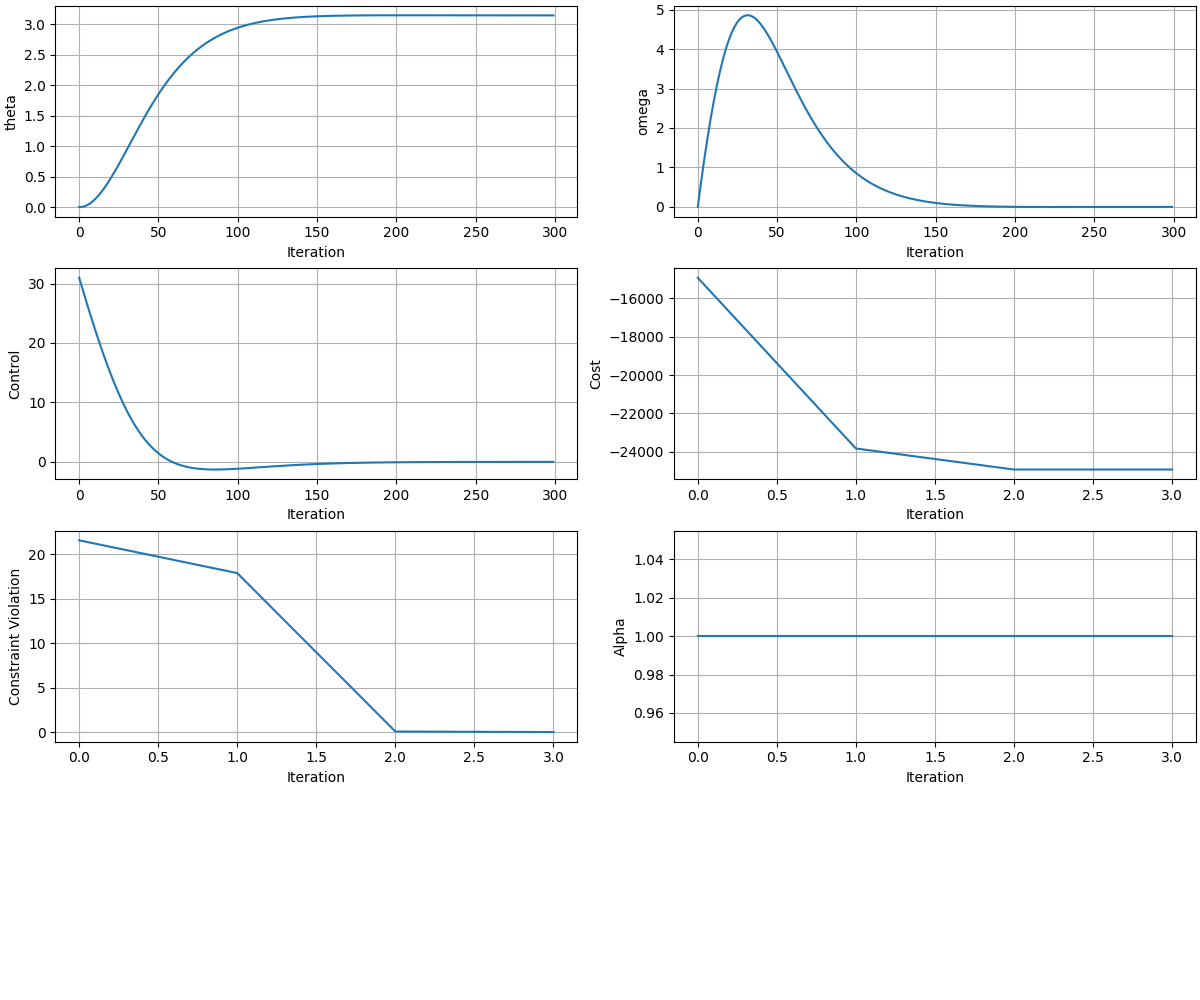

In [10]:
plt.figure(figsize=[12,10], layout='constrained')
plt.subplot(4,2,1)
plt.plot(theta[0,:],label='theta')
plt.ylabel('theta')
plt.xlabel('Iteration')
plt.grid()

plt.subplot(4,2,2)
plt.plot(omega[0,:],label='omega')
plt.ylabel('omega')
plt.xlabel('Iteration')
plt.grid()

plt.subplot(4,2,3)
plt.plot(u[0,:],label='control')
plt.ylabel('Control')
plt.xlabel('Iteration')
plt.grid()

plt.subplot(4,2,4)
plt.plot(cost_list,label='Cost')
plt.ylabel('Cost')
plt.xlabel('Iteration')
plt.grid()

plt.subplot(4,2,5)
plt.plot(c_list,label='c_list')
plt.ylabel('Constraint Violation')
plt.xlabel('Iteration')
plt.grid()

plt.subplot(4,2,6)
plt.plot(alpha_list,label='Alpha')
plt.ylabel('Alpha')
plt.xlabel('Iteration')
plt.grid()
